In [1]:
import warnings             # to remove warning messages
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow.keras as keras
import keras.backend as K
import tensorflow.keras.layers as L
from glob import glob
from PIL import Image
import imghdr
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D, Concatenate, Conv2DTranspose, GlobalAveragePooling2D, BatchNormalization, ReLU, Reshape, Resizing, Add, SeparableConv2D, MultiHeadAttention, UpSampling2D, LayerNormalization, ZeroPadding2D, DepthwiseConv2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tqdm import tqdm

2024-06-27 14:28:03.530790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 14:28:03.530898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 14:28:03.693039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Processing**

In [2]:
#@title Creating Data Pipeline and Data Preprocessing

image_directory = '/kaggle/input/3dircadb-hu-clipped/CT_Images'
mask_directory = '/kaggle/input/3dircadb-hu-clipped/Liver_masks'

SIZE = 256
batch_size = 8
image_dataset = []
mask_dataset = []

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "CT_Images", "*.jpg")))
    masks = sorted(glob(os.path.join(path, "Liver_masks", "*.jpg")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (SIZE, SIZE))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (SIZE, SIZE))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_image(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([SIZE, SIZE, 3])
    y.set_shape([SIZE, SIZE, 3])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset('/kaggle/input/3dircadb-hu-clipped')

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

Train: 1239 - 1239
Valid: 412 - 412
Test : 412 - 412


In [3]:
def load_image(path, size, mask=False):
    image = Image.open(path)
    image = image.resize((size, size))

    if mask:
        image = image.convert('L')  # Convert to grayscale
    else:
        image = image.convert('RGB')  # Convert to RGB

    image = np.array(image)
    return image

def load_data_testing(root_path, size):
    images = []
    masks = []

    image_folder = os.path.join(root_path, 'CT_Images')
    mask_folder = os.path.join(root_path, 'Liver_masks')

    for image_path in sorted(glob(os.path.join(image_folder, '*jpg'))):
        img_id = os.path.basename(image_path).split('.')[0]
        mask_path = os.path.join(mask_folder, f'{img_id}.jpg')

        img = load_image(image_path, size) / 255.0
        mask = load_image(mask_path, size, mask=True) / 255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

size = 256   # image size: 256x256
root_path = '/kaggle/input/3dircadb-hu-clipped'
X_test, y_test = load_data_testing(root_path, size)

In [4]:
print(f"X shape: {X_test.shape}     |  y shape: {y_test.shape}")

y_test = np.expand_dims(y_test, -1)

print(f"\nX shape: {X_test.shape}  |  y shape: {y_test.shape}")

X shape: (2063, 256, 256, 3)     |  y shape: (2063, 256, 256)

X shape: (2063, 256, 256, 3)  |  y shape: (2063, 256, 256, 1)


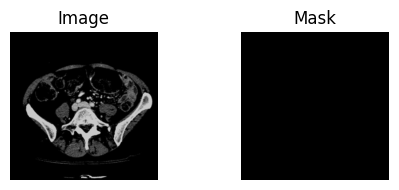

In [5]:
#### Visualisation of testing images

image = X_test[1]
mask = y_test[1]

fig, axes = plt.subplots(1, 2, figsize=(5, 2))
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Image')

axes[1].imshow(mask*255, cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
axes[1].set_title('Mask')

plt.tight_layout()
plt.show()

# **Deep Learning Models Creation, Training, Evaluating, Saving, Performance Graph etc.**

In [6]:
#@title Score Calculations

smooth = 1e-15
def dice_score(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_score(y_true, y_pred)

# Hybrid Loss
def custom_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss(y_true, y_pred)
    total_loss = dice+(2*focal)
    return total_loss

def iou(y_true, y_pred):
    smooth = K.epsilon()
    y_true_flat = tf.keras.layers.Flatten()(tf.keras.backend.cast(y_true, 'float32'))
    y_pred_flat = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.keras.backend.sum(y_true_flat * y_pred_flat)
    union = tf.keras.backend.sum(y_true_flat) + tf.keras.backend.sum(y_pred_flat) - intersection + smooth
    iou = (intersection + smooth) / union
    return iou

def recall(y_true, y_pred):
    smooth = K.epsilon()
    y_pred_pos = tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1))
    y_true_flat = tf.keras.layers.Flatten()(tf.keras.backend.cast(y_true, 'float32'))
    y_pred_flat = tf.keras.layers.Flatten()(y_pred_pos)
    tp = tf.keras.backend.sum(y_true_flat * y_pred_flat)
    fn = tf.keras.backend.sum(y_true_flat * (1 - y_pred_flat))
    recall = (tp + smooth) / (tp + fn + smooth)
    return recall

def precision(y_true, y_pred):
    smooth = K.epsilon()
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_true_flat = tf.keras.layers.Flatten()(tf.keras.backend.cast(y_true, 'float32'))
    y_pred_flat = tf.keras.layers.Flatten()(y_pred_pos)
    tp = tf.keras.backend.sum(y_true_flat * y_pred_flat)
    fp = tf.keras.backend.sum((1 - y_true_flat) * y_pred_flat)
    precision = (tp + smooth) / (tp + fp + smooth)
    return precision



def iou_loss(y_true, y_pred):
    loss = 1 - iou(y_true, y_pred)
    return loss

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    y_true = tf.cast(y_true, tf.float32)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_weight = alpha * tf.pow(1 - pt, gamma)
    loss = tf.reduce_mean(-focal_weight * tf.math.log(pt))
    return loss

def bce_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))
    return loss

# Traversky Loss
!pip install keras-unet-collection
from keras_unet_collection import losses

def traversky_loss(y_true, y_pred):
    loss_trav = losses.focal_tversky(y_true, y_pred, alpha=0.5, gamma=4/3)
    return loss_trav


# Hybrid Loss
def hybrid_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = bce_loss(y_true, y_pred)
    trav = traversky_loss(y_true, y_pred)
    total_loss = dice+trav+bce
    return total_loss

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.7 MB/s eta 0:00:00


In [7]:
#@title Richards Curve Layer

from tensorflow.keras.layers import Layer, Concatenate
import numpy as np
import math

class RichardsCurveLayer(Layer):
    def __init__(self, patch_dim=2, mode='global', **kwargs):
        super(RichardsCurveLayer, self).__init__(**kwargs)
        self.patch_dim = patch_dim
        self.mode = mode

    def channel_attention(self, x):
        A=0.1; K=1.0; C=1.0; Q=1.0; V=1.0
        l = []
        for i in range(x.shape[-1]):
            channel = tf.expand_dims(x[:, :, :, i], axis=-1)
            Xmax = tf.expand_dims(tf.reduce_max(channel, axis=None), axis=-1)
            Xmin = tf.expand_dims(tf.reduce_min(channel, axis=None), axis=-1)
            condition = Xmax[0] == Xmin[0]
            Xmin = tf.expand_dims(tf.where(condition, (Xmin[0]-0.000001), Xmin[0]), axis=-1)
            H = ((Xmin + Xmax)/2.0) * (-1)
            B = (6.801283034 * 2)/(Xmax - Xmin)
            E=1.1
            p = -(A + ((K - A)/((C + (Q * tf.math.exp((-1) * (B * (channel + H)))))**(1/V))))+E
            l.append(p)

        prediction = Concatenate(axis=-1)(l)

        return prediction

    def global_attention(self, x):
        A=0.1; K=1.0; C=1.0; Q=1.0; V=1.0
        Xmax = tf.expand_dims(tf.reduce_max(x, axis=None), axis=-1)
        Xmin = tf.expand_dims(tf.reduce_min(x, axis=None), axis=-1)
        condition = Xmax[0] == Xmin[0]
        Xmin = tf.expand_dims(tf.where(condition, (Xmin[0]-0.000001), Xmin[0]), axis=-1)
        H = ((Xmin + Xmax)/2.0) * (-1)
        B = (6.801283034 * 2)/(Xmax - Xmin)
        E = 1.1
        prediction = -(A + ((K - A)/((C + (Q * tf.math.exp((-1) * (B * (x + H)))))**(1/V))))+E

        return prediction
    
    def global_attention_g(self, x):
        A=0.1; K=1.0; C=1.0; Q=1.0; V=1.0
        Xmax = tf.expand_dims(tf.reduce_max(x, axis=None), axis=-1)
        Xmin = tf.expand_dims(tf.reduce_min(x, axis=None), axis=-1)
        condition = Xmax[0] == Xmin[0]
        Xmin = tf.expand_dims(tf.where(condition, (Xmin[0]-0.000001), Xmin[0]), axis=-1)
        H = ((Xmin + Xmax)/2.0) * (-1)
        B = (6.801283034 * 2)/(Xmax - Xmin)
        prediction = A + ((K - A)/((C + (Q * tf.math.exp((-1) * (B * (x + H)))))**(1/V)))

        return prediction

    def spatial_patchification(self, x, patch_dim=2):
        a=0; b=patch_dim; c=0; d=patch_dim; A=0.1; K=1.0; C=1.0; Q=1.0; V=1.0; prediction=None

        while b<=x.shape[-3]:

            while d<=x.shape[-2]:
                cube = x[:, a:b, c:d, :]
                Xmax = tf.expand_dims(tf.reduce_max(cube, axis=None), axis=-1)
                Xmin = tf.expand_dims(tf.reduce_min(cube, axis=None), axis=-1)
                condition = Xmax[0] == Xmin[0]
                Xmin = tf.expand_dims(tf.where(condition, (Xmin[0]-0.000001), Xmin[0]), axis=-1)
                H = ((Xmin + Xmax)/2.0) * (-1)
                B = (6.801283034 * 2)/(Xmax - Xmin)
                p = A + ((K - A)/((C + (Q * tf.math.exp((-1) * (B * (cube + H)))))**(1/V)))

                if c == 0 and d == patch_dim:
                    pred = p
                else:
                    pred = Concatenate(axis=-2)([pred, p])

                c+=patch_dim; d+=patch_dim

            if a == 0 and b == patch_dim:
                prediction = pred
            else:
                prediction = Concatenate(axis=-3)([prediction, pred])
            a+=patch_dim; b+=patch_dim; c=0; d=patch_dim
        return x*prediction

    def call(self, inputs):
        if self.mode == "global":
            s1 = self.global_attention(inputs)
            s2 = self.channel_attention(inputs)
            s = s1 * s2
            return inputs*s
        elif self.mode == "global_only":
            s1 = self.global_attention_g(inputs)
            return inputs*s1
        elif self.mode == "local":
            return self.spatial_patchification(inputs, self.patch_dim)

In [8]:
#@title Deep Model
def mod(img_shape):
    input_x = Input(shape=img_shape, name='input_1')

    # Conv1 block
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', use_bias=False, name='Conv1')(input_x)
    x = BatchNormalization(name='bn_Conv1')(x)
    x = ReLU(name='Conv1_relu')(x)

    # Expanded Conv block
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='expanded_conv_depthwise')(x)
    x = BatchNormalization(name='expanded_conv_depthwise_BN')(x)
    x = ReLU(name='expanded_conv_depthwise_relu')(x)
    x = Conv2D(16, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='expanded_conv_project')(x)
    x = BatchNormalization(name='expanded_conv_project_BN')(x)

    # block_1
    x = Conv2D(96, (1, 1), strides=(1, 1), padding='same', name='block_1_expand')(x)
    x = BatchNormalization(name='block_1_expand_BN')(x)
    x = ReLU(name='block_1_expand_relu')(x)
    x = ZeroPadding2D(padding=((1, 0), (1, 0)), name='block_1_pad')(x)
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding='valid', use_bias=False, name='block_1_depthwise')(x)
    x = BatchNormalization(name='block_1_depthwise_BN')(x)
    x = ReLU(name='block_1_depthwise_relu')(x)
    x = Conv2D(24, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_1_project')(x)
    x_1 = BatchNormalization(name='block_1_project_BN')(x)

    # block_2
    x = Conv2D(144, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_2_expand')(x_1)
    x = BatchNormalization(name='block_2_expand_BN')(x)
    x = ReLU(name='block_2_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_2_depthwise')(x)
    x = BatchNormalization(name='block_2_depthwise_BN')(x)
    x = ReLU(name='block_2_depthwise_relu')(x)
    x = Conv2D(24, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_2_project')(x)
    x = BatchNormalization(name='block_2_project_BN')(x)
    x = Add(name='block_2_add')([x_1, x])

    # block_3
    x = Conv2D(144, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_3_expand')(x)
    x = BatchNormalization(name='block_3_expand_BN')(x)
    x = ReLU(name='block_3_expand_relu')(x)
    x = ZeroPadding2D(padding=((1, 0), (1, 0)), name='block_3_pad')(x)
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding='valid', use_bias=False, name='block_3_depthwise')(x)
    x = BatchNormalization(name='block_3_depthwise_BN')(x)
    x = ReLU(name='block_3_depthwise_relu')(x)
    x = Conv2D(32, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_3_project')(x)
    x_3 = BatchNormalization(name='block_3_project_BN')(x)

    # block_4
    x = Conv2D(192, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_4_expand')(x_3)
    x = BatchNormalization(name='block_4_expand_BN')(x)
    x = ReLU(name='block_4_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_4_depthwise')(x)
    x = BatchNormalization(name='block_4_depthwise_BN')(x)
    x = ReLU(name='block_4_depthwise_relu')(x)
    x = Conv2D(32, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_4_project')(x)
    x = RichardsCurveLayer(mode='global', name='encoder_richard')(x)     # Encoder Richards
    x = BatchNormalization(name='block_4_project_BN')(x)
    x_4 = Add(name='block_4_add')([x_3, x])

    # block_5
    x = Conv2D(192, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_5_expand')(x_4)
    x = BatchNormalization(name='block_5_expand_BN')(x)
    x = ReLU(name='block_5_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_5_depthwise')(x)
    x = BatchNormalization(name='block_5_depthwise_BN')(x)
    x = ReLU(name='block_5_depthwise_relu')(x)
    x = Conv2D(32, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_5_project')(x)
    x = BatchNormalization(name='block_5_project_BN')(x)
    x = Add(name='block_5_add')([x_4, x])

    # block_6
    x = Conv2D(192, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_6_expand')(x)
    x = BatchNormalization(name='block_6_expand_BN')(x)
    x = ReLU(name='block_6_expand_relu')(x)
    x = ZeroPadding2D(padding=((1, 0), (1, 0)), name='block_6_pad')(x)
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding='valid', use_bias=False, name='block_6_depthwise')(x)
    x = BatchNormalization(name='block_6_depthwise_BN')(x)
    x = ReLU(name='block_6_depthwise_relu')(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_6_project')(x)
    x_6 = BatchNormalization(name='block_6_project_BN')(x)

    # block_7
    x = Conv2D(384, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_7_expand')(x_6)
    x = BatchNormalization(name='block_7_expand_BN')(x)
    x = ReLU(name='block_7_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_7_depthwise')(x)
    x = BatchNormalization(name='block_7_depthwise_BN')(x)
    x = ReLU(name='block_7_depthwise_relu')(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_7_project')(x)
    x = BatchNormalization(name='block_7_project_BN')(x)
    x_7 = Add(name='block_7_add')([x_6, x])

    # block_8
    x = Conv2D(384, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_8_expand')(x_7)
    x = BatchNormalization(name='block_8_expand_BN')(x)
    x = ReLU(name='block_8_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_8_depthwise')(x)
    x = BatchNormalization(name='block_8_depthwise_BN')(x)
    x = ReLU(name='block_8_depthwise_relu')(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_8_project')(x)
    x = BatchNormalization(name='block_8_project_BN')(x)
    x_8 = Add(name='block_8_add')([x_7, x])

    # block_9
    x = Conv2D(384, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_9_expand')(x_8)
    x = BatchNormalization(name='block_9_expand_BN')(x)
    x = ReLU(name='block_9_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_9_depthwise')(x)
    x = BatchNormalization(name='block_9_depthwise_BN')(x)
    x = ReLU(name='block_9_depthwise_relu')(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_9_project')(x)
    x = BatchNormalization(name='block_9_project_BN')(x)
    x = Add(name='block_9_add')([x_8, x])

    # block_10
    x = Conv2D(384, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_10_expand')(x)
    x = BatchNormalization(name='block_10_expand_BN')(x)
    x = ReLU(name='block_10_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_10_depthwise')(x)
    x = BatchNormalization(name='block_10_depthwise_BN')(x)
    x = ReLU(name='block_10_depthwise_relu')(x)
    x = Conv2D(96, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_10_project')(x)
    x_10 = BatchNormalization(name='block_10_project_BN')(x)

    # block_11
    x = Conv2D(576, (1, 1), padding='same', use_bias=False, name='block_11_expand')(x_10)
    x = BatchNormalization(name='block_11_expand_BN')(x)
    x = ReLU(name='block_11_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), padding='same', use_bias=False, name='block_11_depthwise')(x)
    x = BatchNormalization(name='block_11_depthwise_BN')(x)
    x = ReLU(name='block_11_depthwise_relu')(x)
    x = Conv2D(96, (1, 1), padding='same', use_bias=False, name='block_11_project')(x)
    x = BatchNormalization(name='block_11_project_BN')(x)
    x_11 = Add(name='block_11_add')([x_10, x])

    # block_12
    x = Conv2D(576, (1, 1), padding='same', use_bias=False, name='block_12_expand')(x_11)
    x = BatchNormalization(name='block_12_expand_BN')(x)
    x = ReLU(name='block_12_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), padding='same', use_bias=False, name='block_12_depthwise')(x)
    x = BatchNormalization(name='block_12_depthwise_BN')(x)
    x = ReLU(name='block_12_depthwise_relu')(x)
    x = Conv2D(96, (1, 1), padding='same', use_bias=False, name='block_12_project')(x)
    x = BatchNormalization(name='block_12_project_BN')(x)
    x = Add(name='block_12_add')([x_11, x])

    # block_13
    x = Conv2D(576, (1, 1), padding='same', use_bias=False, name='block_13_expand')(x)
    x = BatchNormalization(name='block_13_expand_BN')(x)
    x = ReLU(name='block_13_expand_relu')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='block_13_pad')(x)
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding='valid', use_bias=False, name='block_13_depthwise')(x)
    x = BatchNormalization(name='block_13_depthwise_BN')(x)
    x = ReLU(name='block_13_depthwise_relu')(x)
    x = Conv2D(160, (1, 1), padding='same', use_bias=False, name='block_13_project')(x)
    x_13 = BatchNormalization(name='block_13_project_BN')(x)

    # block_14
    x = Conv2D(960, (1, 1), padding='same', use_bias=False, name='block_14_expand')(x_13)
    x = BatchNormalization(name='block_14_expand_BN')(x)
    x = ReLU(name='block_14_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), padding='same', use_bias=False, name='block_14_depthwise')(x)
    x = BatchNormalization(name='block_14_depthwise_BN')(x)
    x = ReLU(name='block_14_depthwise_relu')(x)
    x = Conv2D(160, (1, 1), padding='same', use_bias=False, name='block_14_project')(x)
    x = BatchNormalization(name='block_14_project_BN')(x)
    x_14 = Add(name='block_14_add')([x_13, x])

    # block_15
    x = Conv2D(960, (1, 1), padding='same', use_bias=False, name='block_15_expand')(x_14)
    x = BatchNormalization(name='block_15_expand_BN')(x)
    x = ReLU(name='block_15_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), padding='same', use_bias=False, name='block_15_depthwise')(x)
    x = BatchNormalization(name='block_15_depthwise_BN')(x)
    x = ReLU(name='block_15_depthwise_relu')(x)
    x = Conv2D(160, (1, 1), padding='same', use_bias=False, name='block_15_project')(x)
    x = BatchNormalization(name='block_15_project_BN')(x)
    x = Add(name='block_15_add')([x_14, x])

    # block_16
    x = Conv2D(960, (1, 1), padding='same', use_bias=False, name='block_16_expand')(x)
    x = BatchNormalization(name='block_16_expand_BN')(x)
    x = ReLU(name='block_16_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), padding='same', use_bias=False, name='block_16_depthwise')(x)
    x = BatchNormalization(name='block_16_depthwise_BN')(x)
    x = ReLU(name='block_16_depthwise_relu')(x)
    x = Conv2D(320, (1, 1), padding='same', use_bias=False, name='block_16_project')(x)
    x = BatchNormalization(name='block_16_project_BN')(x)

    # Final
    x = Conv2D(1280, (1, 1), padding='same', use_bias=False, name='Conv_1')(x)
    x = BatchNormalization(name='Conv_1_bn')(x)
    x = ReLU(name='out_relu')(x)

    model = Model(inputs=input_x, outputs=x, name="MobileNetV2")
    return model


def unet(img_shape):

    def encoder(input_x):

        mobilenet = mod(input_x)
        mobilenet.trainable = True

        x7_en = 'block_1_expand_relu' # (128, 128, 96)
        x9_en = 'block_3_expand_relu' # (64, 64, 144)
        x11_en = 'block_6_expand_relu' # (32, 32, 192)
        x13_en = 'block_13_expand_relu' # (16, 16, 576)
        x14_en = 'block_14_add' # (8, 8, 160)

        x7_en = mobilenet.get_layer(x7_en).output
        x9_en = mobilenet.get_layer(x9_en).output
        x11_en = mobilenet.get_layer(x11_en).output
        x13_en = mobilenet.get_layer(x13_en).output
        x14_en = mobilenet.get_layer(x14_en).output

        return mobilenet, x14_en, x7_en, x9_en, x11_en, x13_en


    def decoder(input_x, x7_en, x9_en, x11_en, x13_en, name='name'):

        # Decoder 1
        x1_de = UpSampling2D(size=(2,2))(input_x)
        x11_de = Concatenate(axis=-1)([x1_de, x13_en])
        x2_de = Conv2D(128, (3,3), activation='relu', padding='same')(x11_de)
        x3_de = UpSampling2D(size=(2,2))(x2_de)
        x31_de = Concatenate(axis=-1)([x3_de, x11_en])
        x4_de = Conv2D(64, (3,3), activation='relu', padding='same')(x31_de)
        x4_de = RichardsCurveLayer(mode='global_only', name='decoder_richard')(x4_de)     # Decoder Richard
        x5_de = UpSampling2D(size=(2,2))(x4_de)
        x51_de = Concatenate(axis=-1)([x5_de, x9_en])
        x6_de = Conv2D(32, (3,3), activation='relu', padding='same')(x51_de)
        x7_de = UpSampling2D(size=(2,2))(x6_de)
        x71_de = Concatenate(axis=-1)([x7_de, x7_en])
        x8_de = Conv2D(16, (3,3), activation='relu', padding='same')(x71_de)
        x9_de = UpSampling2D(size=(2,2))(x8_de)
        x14_de = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x9_de)

        return x14_de

    model, FB, x7_en, x9_en, x11_en, x13_en = encoder(img_shape)
    x13_en = RichardsCurveLayer(patch_dim=8, mode='local', name='richard_curve_local')(x13_en)    # Skip Richard
    dec_in = Conv2D(160, (3,3), activation='relu', padding='same')(FB)

    DE_B = decoder(dec_in, x7_en, x9_en, x11_en, x13_en, name='output')

    model = Model(inputs=model.input, outputs=[DE_B], name="MobileRichard")
    return model


input_shape = (256, 256, 3)

model = unet(input_shape)
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=hybrid_loss, metrics=['accuracy', 'Precision', 'Recall', dice_score, iou])
model.summary()

Model: "MobileRichard"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,632 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,382,563 (9.09 MB)

 Trainable params: 2,359,651 (9.00 MB)

 Non-trainable params: 22,912 (89.50 KB)

In [9]:
#@title Training the Models

logdir='/kaggle/working/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/mobilenet.weights.h5',
    monitor='val_dice_score',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
   )

history = model.fit(train_dataset,
                    epochs = 200,
                    batch_size = 32,
                    validation_data = valid_dataset,
                    verbose = 1,
                    callbacks=[tensorboard_callback, model_checkpoint_callback],
                    shuffle = True)

Epoch 1/200


I0000 00:00:1719498650.584606     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - Precision: 0.5868 - Recall: 0.5776 - accuracy: 0.6419 - dice_score: 0.5612 - iou: 0.4258 - loss: 1.6822
Epoch 1: val_dice_score improved from -inf to 0.00044, saving model to /kaggle/working/mobilenet.weights.h5
155/155 ━━━━━━━━━━━━━━━━━━━━ 181s 578ms/step - Precision: 0.5879 - Recall: 0.5776 - accuracy: 0.6421 - dice_score: 0.5619 - iou: 0.4265 - loss: 1.6807 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3090 - val_dice_score: 4.3633e-04 - val_iou: 2.1824e-04 - val_loss: 2.6927
Epoch 2/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - Precision: 0.8965 - Recall: 0.5708 - accuracy: 0.5251 - dice_score: 0.7637 - iou: 0.6350 - loss: 1.2506
Epoch 2: val_dice_score improved from 0.00044 to 0.18168, saving model to /kaggle/working/mobilenet.weights.h5
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - Precision: 0.8966 - Recall: 0.5709 - accuracy: 0.5253 - dice_score: 0.7638 - iou: 0.6352 - loss: 1.2504 - val_Precision: 0.3139 - 

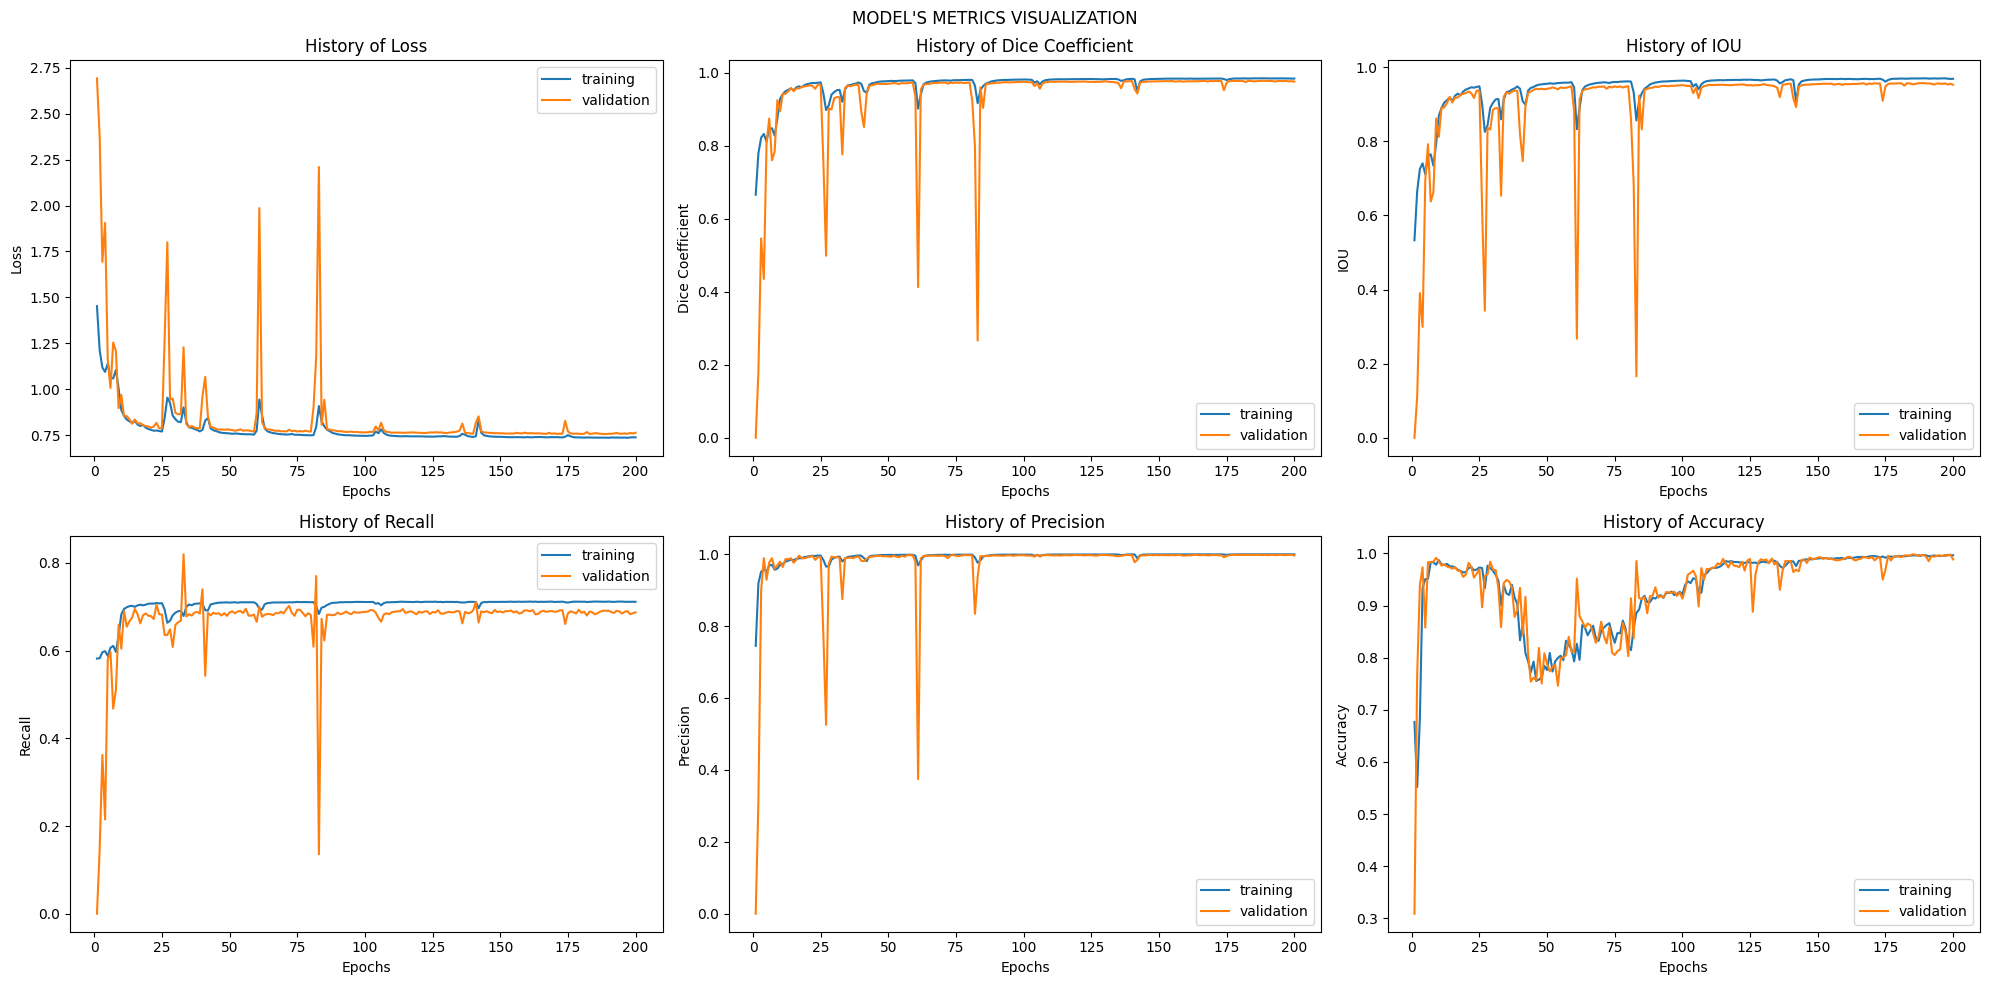

In [10]:
def Train_Val_Plot(loss, val_loss, dice_score, val_dice_score, iou, val_iou, recall, val_recall, precision, val_precision, accuracy, val_accuracy):
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    # Loss plot
    axs[0, 0].plot(range(1, len(loss) + 1), loss)
    axs[0, 0].plot(range(1, len(val_loss) + 1), val_loss)
    axs[0, 0].set_title('History of Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend(['training', 'validation'])

    # Dice Coefficient plot
    axs[0, 1].plot(range(1, len(dice_score) + 1), dice_score)
    axs[0, 1].plot(range(1, len(val_dice_score) + 1), val_dice_score)
    axs[0, 1].set_title('History of Dice Coefficient')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Dice Coefficient')
    axs[0, 1].legend(['training', 'validation'])

    # Mean IOU plot
    axs[0, 2].plot(range(1, len(iou) + 1), iou)
    axs[0, 2].plot(range(1, len(val_iou) + 1), val_iou)
    axs[0, 2].set_title('History of IOU')
    axs[0, 2].set_xlabel('Epochs')
    axs[0, 2].set_ylabel('IOU')
    axs[0, 2].legend(['training', 'validation'])

    # Recall plot
    axs[1, 0].plot(range(1, len(recall) + 1), recall)
    axs[1, 0].plot(range(1, len(val_recall) + 1), val_recall)
    axs[1, 0].set_title('History of Recall')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].legend(['training', 'validation'])

    # Precision plot
    axs[1, 1].plot(range(1, len(precision) + 1), precision)
    axs[1, 1].plot(range(1, len(val_precision) + 1), val_precision)
    axs[1, 1].set_title('History of Precision')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Precision')
    axs[1, 1].legend(['training', 'validation'])

    # Accuracy plot
    axs[1, 2].plot(range(1, len(accuracy) + 1), accuracy)
    axs[1, 2].plot(range(1, len(val_accuracy) + 1), val_accuracy)
    axs[1, 2].set_title('History of Accuracy')
    axs[1, 2].set_xlabel('Epochs')
    axs[1, 2].set_ylabel('Accuracy')
    axs[1, 2].legend(['training', 'validation'])

    plt.tight_layout()
    plt.show()

Train_Val_Plot(
    history.history['loss'], history.history['val_loss'],
    history.history['dice_score'], history.history['val_dice_score'],
    history.history['iou'], history.history['val_iou'],
    history.history['Recall'], history.history['val_Recall'],
    history.history['Precision'], history.history['val_Precision'],
    history.history['accuracy'], history.history['val_accuracy']
)

In [11]:
#@title Evaluating the Models

model.load_weights("/kaggle/working/mobilenet.weights.h5")
model.evaluate(test_dataset, batch_size = 8, verbose = 1)

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - Precision: 0.9980 - Recall: 0.7779 - accuracy: 0.9969 - dice_score: 0.9798 - iou: 0.9604 - loss: 0.7498


[0.7516739368438721,
 0.9969753623008728,
 0.9978203773498535,
 0.7366093993186951,
 0.9791855216026306,
 0.9593055248260498]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


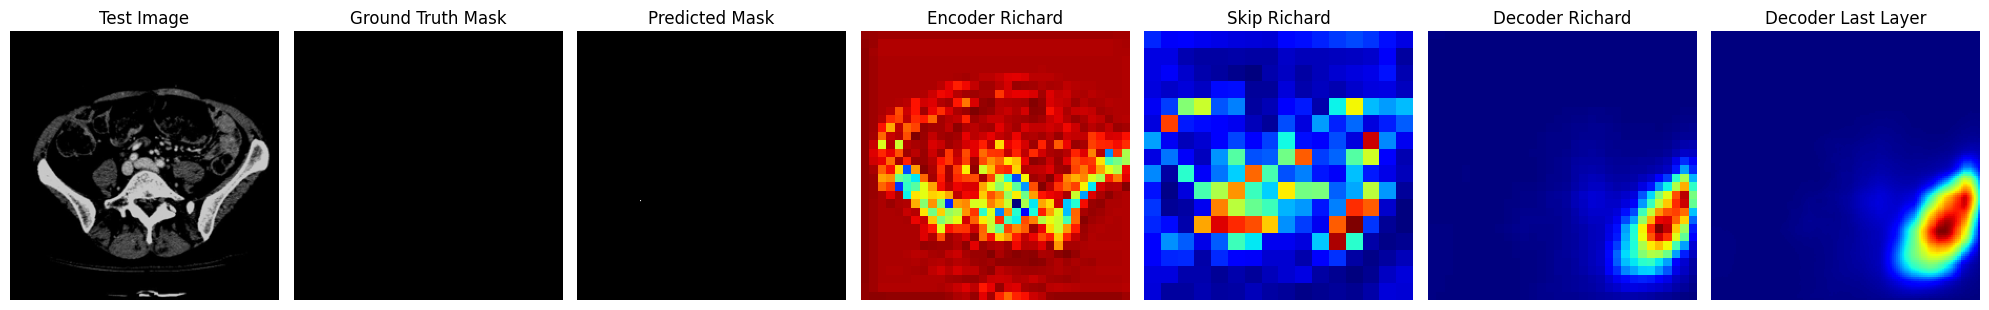

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


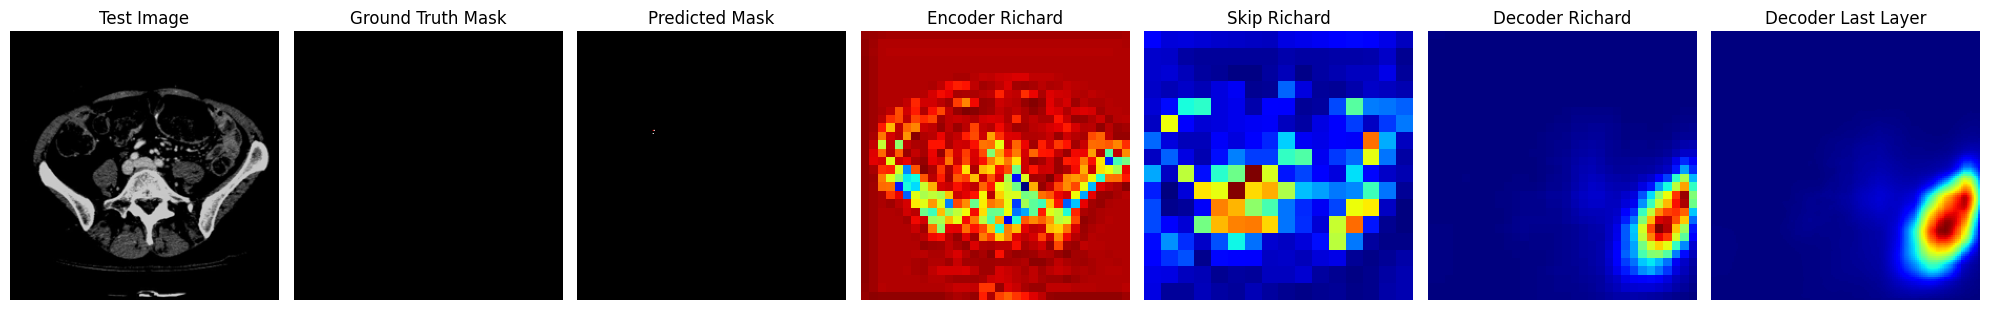

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


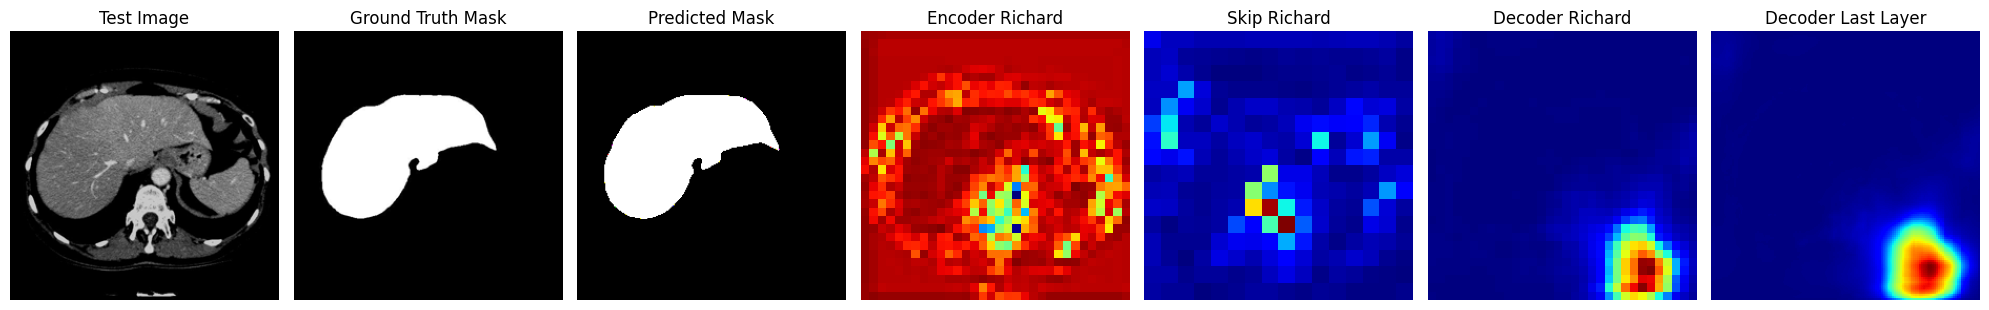

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


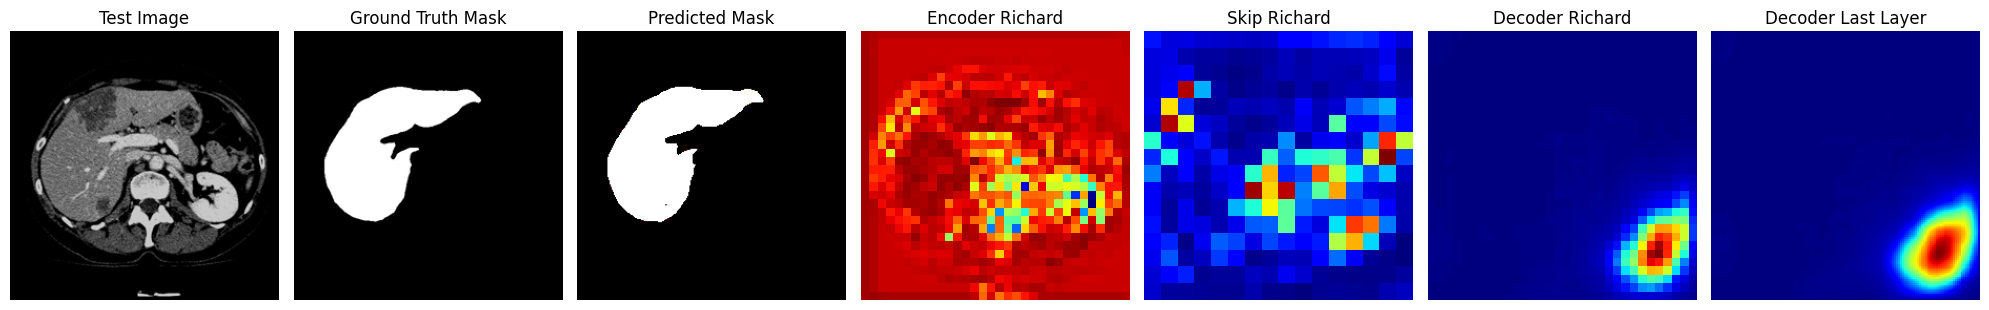

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


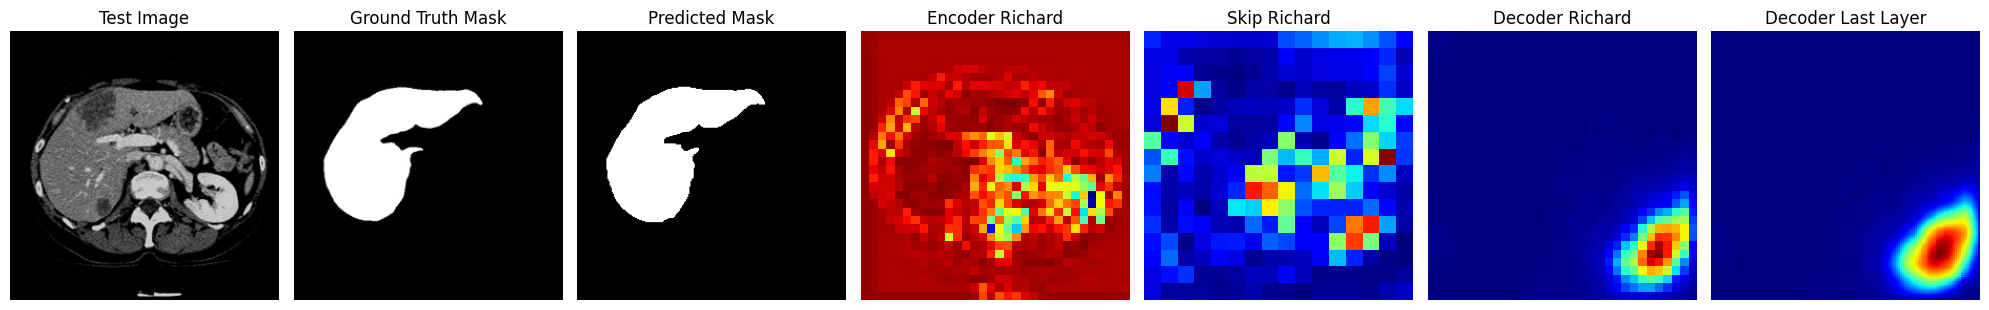

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


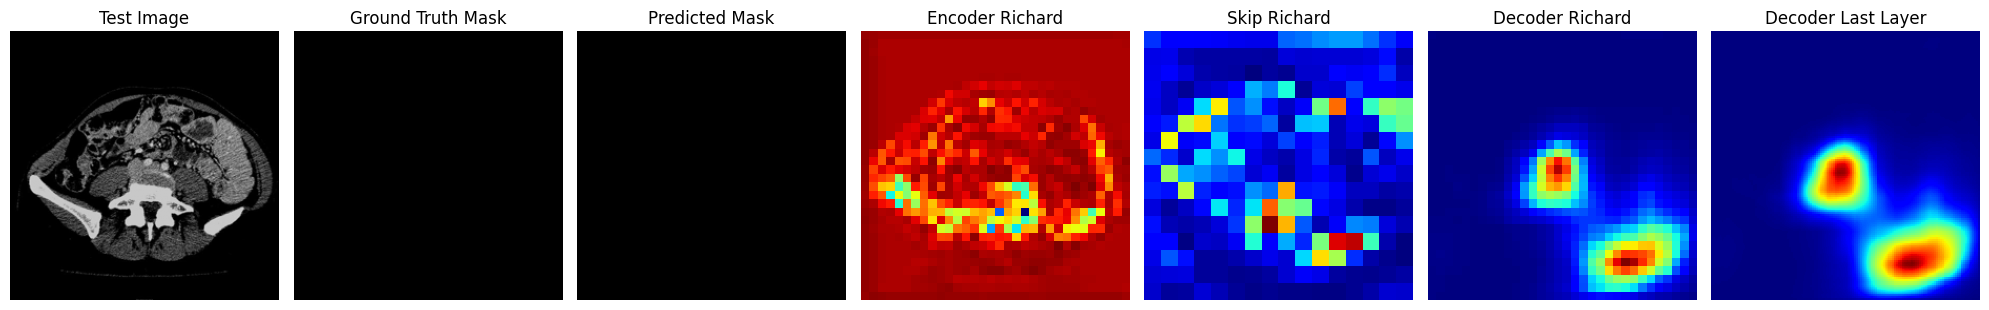

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


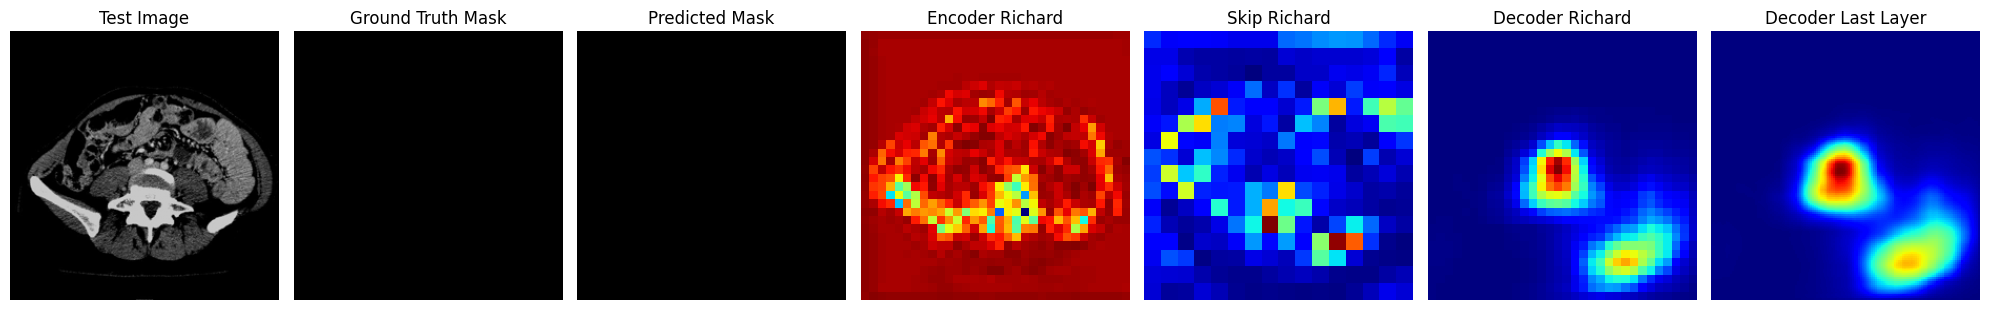

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


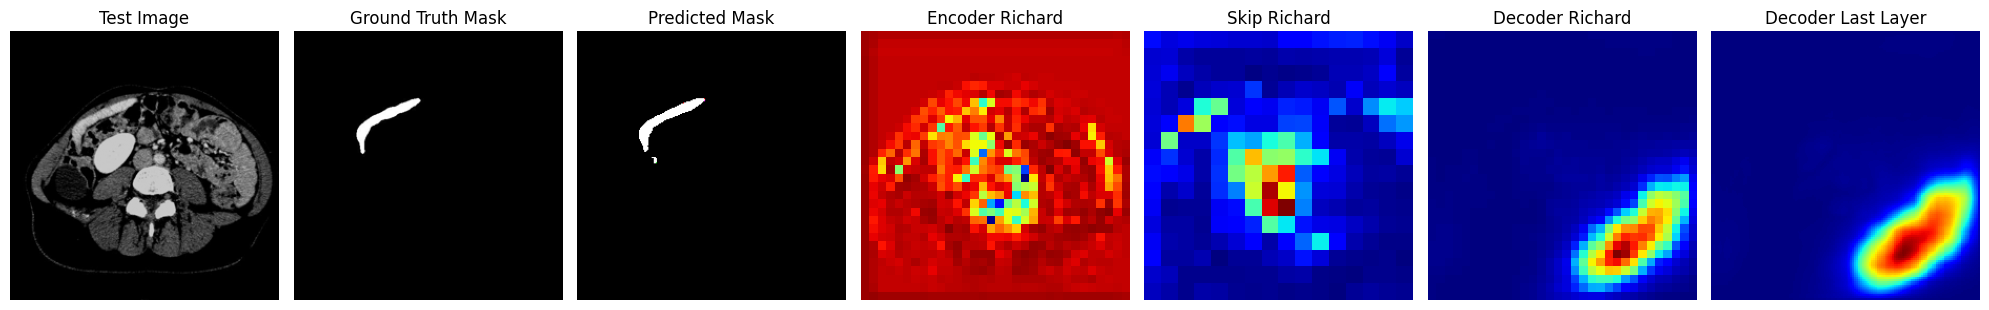

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


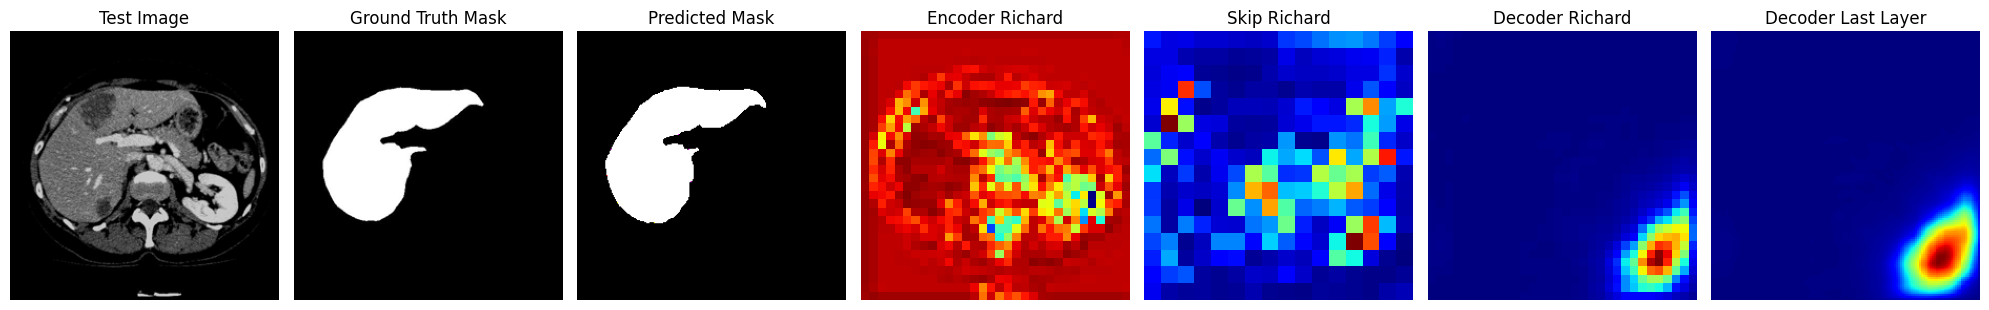

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


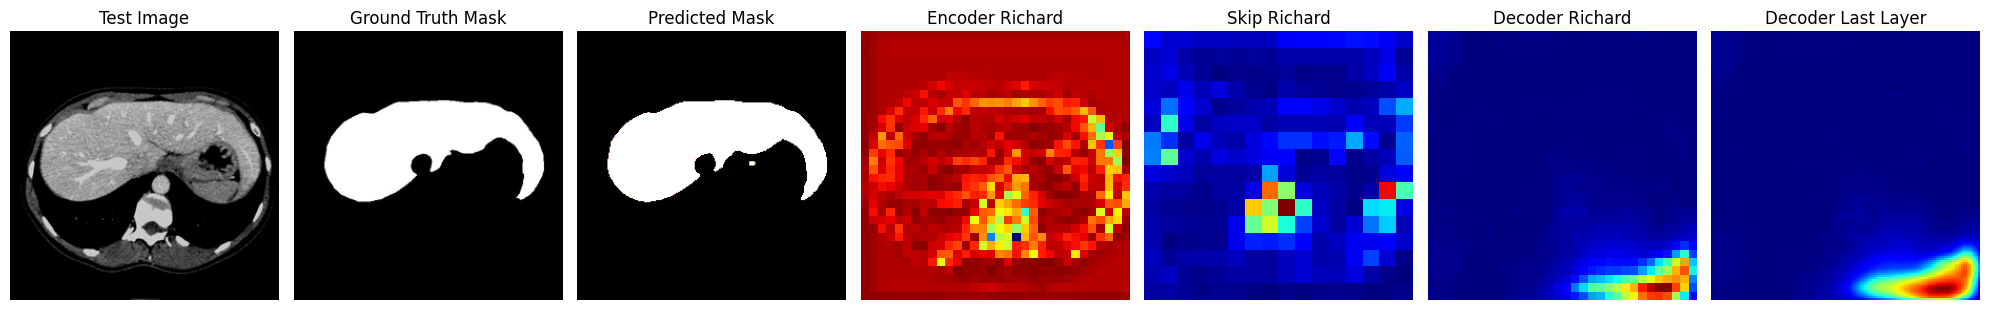

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


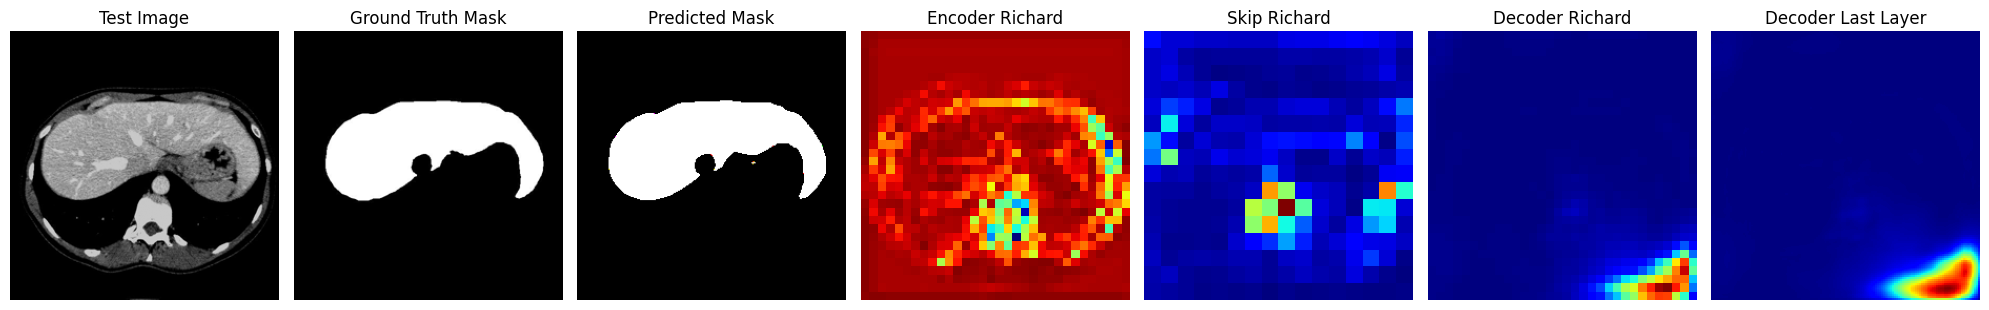

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


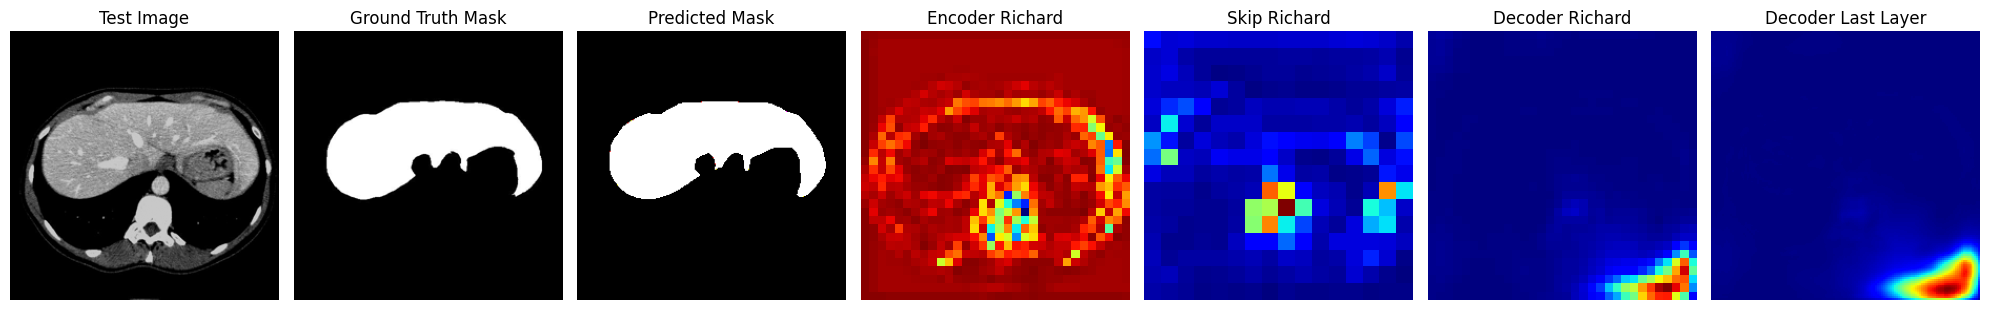

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


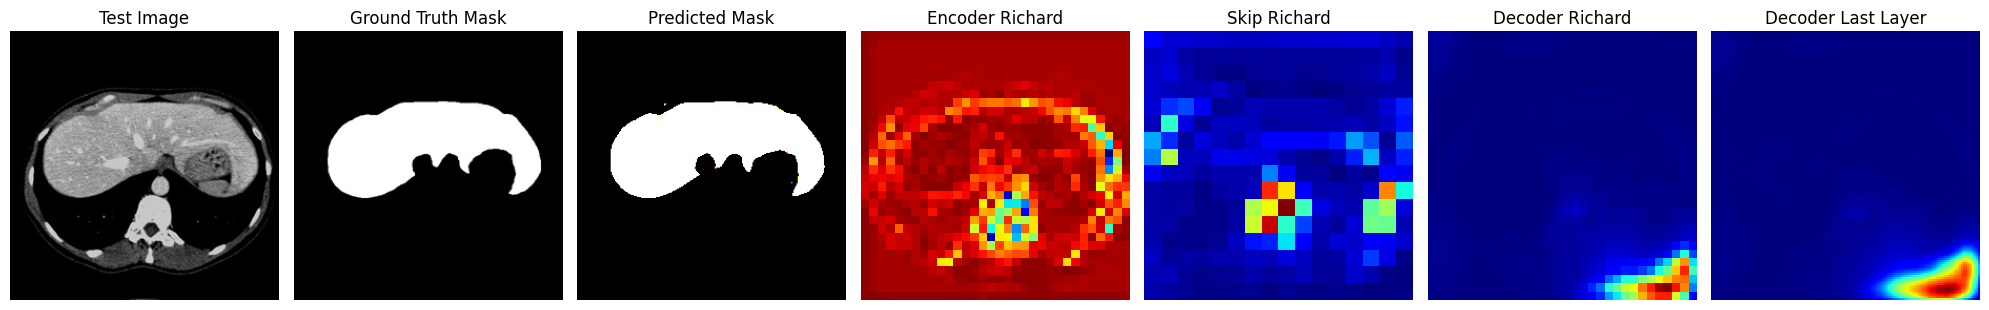

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


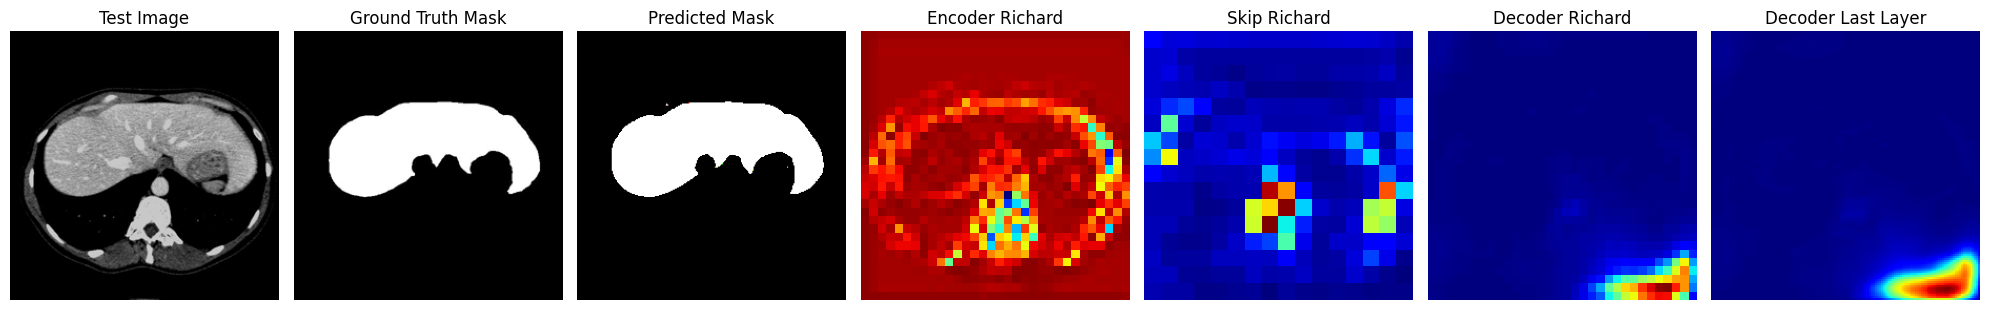

In [12]:
#### Segmentation output

##### Spatial

modeller = Model(inputs=model.input, outputs=[model.get_layer(name="encoder_richard").output,model.get_layer(name="richard_curve_local").output,model.get_layer(name="decoder_richard").output,model.layers[-2].output])

for z in range(0,14):
    # Load one image and corresponding mask from the test dataset
    test_image = X_test[z]  # Replace X_test with your actual test dataset
    test_mask = y_test[z]  # Replace y_test with your actual test masks

    # Reshape the image to match the input shape of the model
    test_image = np.reshape(test_image, (1,) + test_image.shape)

    # Predict the segmentation mask for the test image
    predicted_mask = model.predict(test_image)[0]
    feature_map1, feature_map2, feature_map3, feature_map4 = modeller.predict(test_image)
    feature_map1 = tf.math.reduce_mean(feature_map1, axis=-1, keepdims=True)
    feature_map2 = tf.math.reduce_mean(feature_map2, axis=-1, keepdims=True)
    feature_map3 = tf.math.reduce_mean(feature_map3, axis=-1, keepdims=True)
    feature_map4 = tf.math.reduce_mean(feature_map4, axis=-1, keepdims=True)

    # Convert the predicted mask values to binary (0 or 1)
    predicted_mask_binary = np.where(predicted_mask > 0.5, 1, 0) * 255

    # Create subplots
    fig, axes = plt.subplots(1, len(feature_map1) + 6, figsize=(20, 4))

    # Plot the test image
    axes[0].imshow(test_image[0], cmap='gray')
    axes[0].set_title('Test Image')
    axes[0].axis('off')

    # Plot the ground truth mask
    axes[1].imshow(test_mask, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Plot the predicted mask
    axes[2].imshow(predicted_mask_binary, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    # Plot the feature maps (Set 1)
    for i, fmap in enumerate(feature_map1):
        axes[i + 3].imshow(fmap[:, :, 0], cmap='jet')
        axes[i + 3].set_title(f'Encoder Richard')
        axes[i + 3].axis('off')

    # Plot the feature maps (Set 2)
    for i, fmap in enumerate(feature_map2):
        axes[i + 3 + len(feature_map1)].imshow(fmap[:, :, 0], cmap='jet')
        axes[i + 3 + len(feature_map1)].set_title(f'Skip Richard')
        axes[i + 3 + len(feature_map1)].axis('off')

    # Plot the feature maps (Set 3)
    for i, fmap in enumerate(feature_map3):
        axes[i + 3 + len(feature_map1) + len(feature_map2)].imshow(fmap[:, :, 0], cmap='jet')
        axes[i + 3 + len(feature_map1) + len(feature_map2)].set_title(f'Decoder Richard')
        axes[i + 3 + len(feature_map1) + len(feature_map2)].axis('off')

    # Plot the feature maps (Set 4)
    for i, fmap in enumerate(feature_map4):
        axes[i + 3 + len(feature_map1) + len(feature_map2) + len(feature_map3)].imshow(fmap[:, :, 0], cmap='jet')
        axes[i + 3 + len(feature_map1) + len(feature_map2) + len(feature_map3)].set_title(f'Decoder Last Layer')
        axes[i + 3 + len(feature_map1) + len(feature_map2) + len(feature_map3)].axis('off')

    plt.tight_layout()
    plt.show()